In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#data = pd.read_csv("Data.tsv")

df = pd.read_csv('Data.tsv', sep='\t')
df.drop(df.columns[[0, 4]], axis=1, inplace = True)


In [53]:
#Some data cleaning:
#Converting wrongly inserted cm to international inches: 
#column_name = "Your height (in International inches)"
#boolean_condition =df.iloc[:, 2]>107 (tallest guy ever measured 272cm = 107 inches)
#new_value = df.iloc[:, 2]/2.54

#df.loc[boolean_condition, column_name] = new_value
df.loc[df.iloc[:, 2]>107, ["Your height (in International inches)"]] = (df.iloc[:, 2]/2.54)

df["Your height (in International inches)"] = df["Your height (in International inches)"].apply(lambda x: int(x) if x == x else "")

# Filter all rows for which the person wrongly inserted inches with comma:
df.drop(df[df["Your height (in International inches)"] < 12].index, inplace = True) 

# Filter all rows for which the person wrongly inserted shoe size comma:
df.drop(df[df['Your mean shoe size (In European Continental system)  '] < 12].index, inplace = True) 

##to do: implement as costum transformer. 


In [54]:

df.corr().abs()[["Your height (in International inches)"]]

,Your height (in International inches)
Your mean shoe size (In European Continental system),0.822255
Your height (in International inches),1.000000


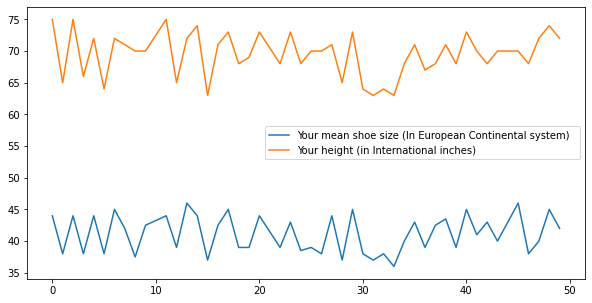

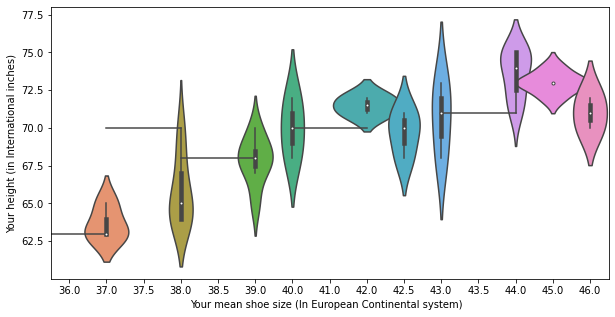

In [107]:
import math
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

df.plot()
plt.show()
#The plot confirms the correlation between windspeed and Windpower generation
fig, axs = plt.subplots(figsize=(10,5))
sns.violinplot(x='Your mean shoe size (In European Continental system)  ', y="Your height (in International inches)", data=df, width=2)

In [58]:
# Defining the test and Fit data
from sklearn.model_selection import train_test_split

# Separate target from predictors (Define X and Y)
y = df.iloc[:,2]
X = df.iloc[:,[0,1]]

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [59]:
# Defining the numerical and categorial columns

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 20 and X_train_full[cname].dtype == "object"]

print("Categorial columns:"+str(categorical_cols))

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
print("numerical columns:"+str(numerical_cols))

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#Lets us peek which datatypes are categorial and which are numerical in our integrated schema
#print(df.info())

Categorial columns:['Which programme are you studying?']
numerical columns:['Your mean shoe size (In European Continental system)  ']


In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# Preprocessing for numerical data

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error'))])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],
    remainder = "passthrough")

In [120]:
# Training 

# from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

#model = RandomForestRegressor(n_estimators=100, random_state=15)
#model = LinearRegression()
model = GaussianNB()
from sklearn.metrics import mean_absolute_error

#Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('model', model)
                           ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Your mean shoe size (In '
                                                   'European Continental '
                                                   'system)  ']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                            

In [121]:
# Preprocessing of validation data, get predictions
#my_pipeline.fit(X_train, y_train)
Y_hat = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, Y_hat)
print('MAE:', score)



MAE: 1.4


In [122]:
from sklearn import metrics
predict_test = my_pipeline.predict(X_valid)
print(metrics.accuracy_score(y_valid, predict_test))

0.4


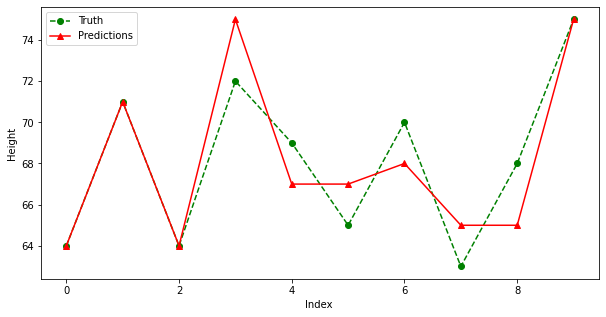

In [133]:
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

#plt.plot(X_valid['Your mean shoe size (In European Continental system)  '], y_valid, "--", label = "Truth")
#plt.plot(X_valid['Your mean shoe size (In European Continental system)  '], Y_hat, label = "Predictions")
plt.plot(X_valid.index, y_valid, color='green', marker='o', linestyle='dashed', label = "Truth")
plt.plot(X_valid.index, Y_hat, color='red', marker='^', linestyle='-', label = "Predictions")
plt.xlabel("Index ")
plt.ylabel("Height")
plt.legend()
plt.show()

In [148]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

print(features[:5])

print(true_labels[:5])

[[  9.77075874   3.27621022]
 [ -9.71349666  11.27451802]
 [ -6.91330582  -9.34755911]
 [-10.86185913 -10.75063497]
 [ -8.50038027  -4.54370383]]
[1 0 2 2 2]


In [150]:
scaled_features = StandardScaler().fit_transform(features)
#print(scaled_features)

[[ 2.13082109  0.25604351]
 [-1.52698523  1.41036744]
 [-1.00130152 -1.56583175]
 [-1.74256891 -1.76832509]
 [-1.29924521 -0.87253446]
 [-0.6091802  -0.96748146]
 [-0.27382069  1.20384743]
 [-1.23815784 -1.11763029]
 [ 1.0309618   1.14757573]
 [-0.57532971 -0.95983806]
 [ 0.68905553  0.04436278]
 [ 1.28502265  0.58676985]
 [ 1.72673134  0.48622328]
 [ 0.91701946  0.10048181]
 [ 0.1220911   0.14198788]
 [-1.42295704 -1.43205314]
 [-0.21168821  1.48245342]
 [-1.41945957 -1.11301166]
 [ 1.52188347 -0.57207183]
 [-0.17617985 -1.70099461]
 [ 2.26318104  0.47775508]
 [ 0.92239799 -0.19130777]
 [-0.82837187 -1.53804066]
 [-0.13964997  0.51871042]
 [-0.64291304 -1.33286646]
 [-0.52398081  1.32693227]
 [-0.76872563  1.23327655]
 [-1.07333975 -0.97623394]
 [-0.06668397  0.3064091 ]
 [ 0.52900408 -0.45607915]
 [ 0.38320194 -0.12419681]
 [ 2.36256256 -0.67309807]
 [-1.87940407 -0.67239826]
 [-1.42115125 -1.33727943]
 [ 0.0120624   1.69458874]
 [-0.12306602  0.88434764]
 [-0.78179844 -1.4334595 ]
 

In [166]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(scaled_features)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_

# Here’s a look at the first five predicted labels
kmeans.labels_[:5]

array([0, 1, 2, 2, 2])

3


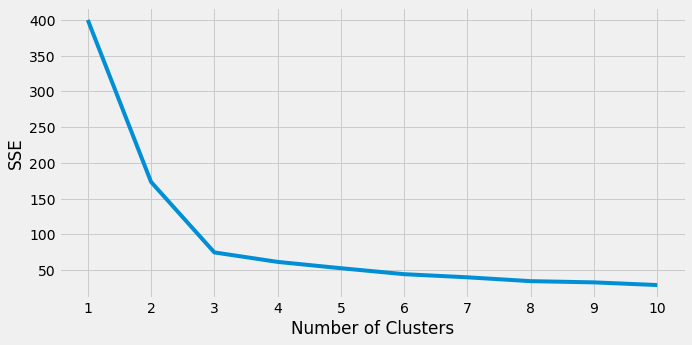

In [172]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

print(kl.elbow)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

